In [1]:
import torch
import torch.nn as nn
from torch import optim
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.utils.data as Data
from einops import rearrange, repeat
from torchsummary import summary
from torch.autograd import Variable

import h5py
import time
import argparse
import numpy as np
import scipy.io as sio
import torch.backends.cudnn as cudnn
from sklearn.preprocessing import StandardScaler

from data_prepare import mirror_hsi
from sklearn.metrics import confusion_matrix
from Utils import plot_confusion_matrix, print_args
from data_prepare import choose_train_and_test_number


from auxiliary_classifier import auxiliary_test_epoch
from auxiliary_classifier import auxiliary_train_epoch
from auxiliary_classifier import auxiliary_valid_epoch


from data_prepare import choose_train_and_test_proportion
from data_prepare import train_and_test_data, train_and_test_label
from Utils import output_metric, classification_map, list_to_colormap

In [2]:
parser = argparse.ArgumentParser("MobileViT")
parser.add_argument('--dataset', choices=['Chikusei', 'Pavia', 'KSC', 'HU2013'], default='KSC', help='dataset to use')
parser.add_argument('--seed', type=int, default=0, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=9, help='size of patches')
parser.add_argument('--epoches', type=int, default=200, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=1, help='num_train_per_class')
parser.add_argument('--train_proportion', type=float, default=0.1, help='num_train_per_class')
args = parser.parse_args(args=[])

In [4]:
# prepare data
if args.dataset == 'Chikusei':
    data = h5py.File('./dataset/Chikusei.mat', 'r')['chikusei']
    data = np.array(data)
    data = np.transpose(data, (2, 1, 0))
    label = sio.loadmat('./dataset/Chikusei_gt.mat')['GT'][0][0][0]
elif args.dataset == 'HU2013':
    data = sio.loadmat('./dataset/Houston.mat')['Houston']
    label = sio.loadmat('./dataset/Houston_gt.mat')['Houston_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat('./dataset/PaviaU.mat')['paviaU']
    label = sio.loadmat('./dataset/PaviaU_gt.mat')['paviaU_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat('./dataset/KSC.mat')['KSC']
    label = sio.loadmat('./dataset/KSC_gt.mat')['KSC_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 13


In [5]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [6]:
total_pos_train, total_pos_test, total_pos_true, number_train, number_test, number_true = \
choose_train_and_test_proportion(label, args.train_proportion)
#  Don't forget to modify the choose_train_and_test_proportion function in the data_prepare module.

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=614, band=176


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_train, x_test, x_true = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, 
                                              total_pos_true, patch_size=args.patch_size)

y_train, y_test, y_true = train_and_test_label(number_train, number_test, number_true, num_classes)

**************************************************
patch_size is : 9
mirror_data shape : [520, 622, 176]
**************************************************
x_train shape = (528, 9, 9, 176), type = float64
x_test  shape = (4683, 9, 9, 176), type = float64
x_true  shape = (5211, 9, 9, 176), type = float64
**************************************************
y_train: shape = (528,), type = int64
y_test: shape = (4683,), type = int64
y_true: shape = (5211,), type = int64
**************************************************


In [8]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (13, 176, 7, 7)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
Train_Label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 176, 7, 7)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
Test_Label = Data.TensorDataset(x_test, y_test)

x_true = torch.from_numpy(x_true.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 176, 7, 7)
print(x_true.shape)
y_true = torch.from_numpy(y_true).type(torch.LongTensor)
True_Label = Data.TensorDataset(x_true, y_true)

train_loader = Data.DataLoader(Train_Label, batch_size=args.batch_size, shuffle=True)
test_loader = Data.DataLoader(Test_Label, batch_size=args.batch_size, shuffle=False)
true_loader = Data.DataLoader(True_Label, batch_size=100, shuffle=False)

torch.Size([528, 176, 9, 9])
torch.Size([4683, 176, 9, 9])
torch.Size([5211, 176, 9, 9])


## Model

In [9]:
def conv_bn(in_ch, out_ch, kernel_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=kernel_size//2), 
        nn.BatchNorm2d(out_ch), 
        nn.SiLU()
    )

In [10]:
class ConvGRUCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvGRUCell, self).__init__()
        
        assert hidden_channels % 2 == 0, 'The number of output channels should be divisible by 2'
        
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = int((kernel_size - 1) / 2)
        
        self.Wxz = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding)
        self.Whz = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxr = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding)
        self.Whr = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
        self.Wxg = nn.Conv2d(self.input_channels, self.hidden_channels, self.kernel_size, 1, self.padding)
        self.Whg = nn.Conv2d(self.hidden_channels, self.hidden_channels, self.kernel_size, 1, self.padding, bias=False)
    
    def forward(self, x, h):
        z = torch.sigmoid(self.Wxz(x) + self.Whz(h))
        r = torch.sigmoid(self.Wxr(x) + self.Whr(h))
        g = torch.tanh(self.Wxg(x) + self.Whg(r * h))
        h = z * h + (1 - z) * g
        return h
    
    def init_hidden(self, batch_size, shape):
        return Variable(torch.zeros(batch_size, self.hidden_channels, shape[0], shape[1])).cuda()
    
    
class ConvGRU(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, steps=8):
        super(ConvGRU, self).__init__()
        self.input_channels = [input_channels] + hidden_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = len(hidden_channels)
        self.steps = steps
        self._all_layers = []
        for i in range(self.num_layers):
            name = 'cell{}'.format(i)
            cell = ConvGRUCell(self.input_channels[i], self.hidden_channels[i], self.kernel_size)
            setattr(self, name, cell)
            self._all_layers.append(cell)

    def forward(self, input_tensor):
        internal_state = []
        outputs = []
        total_channels = input_tensor.size(1)  # 96
        channels_per_step = int(total_channels / self.steps)  # 12
        for step in range(self.steps):
            x = input_tensor[:, step * channels_per_step:(step + 1) * channels_per_step, :, :]
            bsize, _, height, width = x.size()
            for i in range(self.num_layers):
                name = 'cell{}'.format(i)
                if step == 0:
                    h = getattr(self, name).init_hidden(batch_size=bsize, shape=(height, width))
                    internal_state.append(h)
                # do forward
                h = internal_state[i]
                x = getattr(self, name)(x, h)
                internal_state[i] = x
            # only record effective steps
            outputs.append(x)
        result = outputs[0]
        for i in range(self.steps - 1):
            result = torch.cat([result, outputs[i + 1]], dim=1)
        return result  # (batch_size, 48, 7, 7)

In [11]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.ln = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x):
        return self.fn(self.ln(x))
    
    
class FeedForward(nn.Module):
    def __init__(self, dim, mlp_dim, dropout):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, mlp_dim), 
            nn.SiLU(), 
            nn.Dropout(dropout), 
            nn.Linear(mlp_dim, dim), 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, heads, head_dim, dropout):
        super(Attention, self).__init__()
        inner_dim = heads * head_dim
        self.heads = heads
        self.scale = head_dim ** -0.5
        
        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim), 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h=self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)
    
    
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, head_dim, mlp_dim, dropout=0.1):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, head_dim=head_dim, dropout=dropout)), 
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))
    def forward(self, x):
        out = x
        for att, ffn in self.layers:
            out = out + att(out)
            out = out + ffn(out)
        return out

In [13]:
class MobileViT(nn.Module):
    def __init__(self, band, patch_size=9, sub_patch_size=2, dim=8, preliminary_layer_channels=96, 
                 kernel_size=3, depth=3, mlp_dim=16, num_classes=13, steps=8):
        super(MobileViT, self).__init__()
        self.ph, self.pw = sub_patch_size, sub_patch_size
        
        self.conv1 = conv_bn(band, preliminary_layer_channels)  # (batch, 96, 7, 7)
        
        cl_channel = preliminary_layer_channels / steps
        cl_channel = int(cl_channel)  # 16
        cl2_channel = int(cl_channel / 2)  # 8
        # (batch, 64, 7, 7)
        self.convgru = ConvGRU(cl_channel, hidden_channels=[cl_channel, cl2_channel], kernel_size=kernel_size)
        
        output_channel = cl2_channel * steps  # 48
        self.group_normalization = nn.GroupNorm(steps, output_channel)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(output_channel, 32, kernel_size=kernel_size, stride=2),
            nn.BatchNorm2d(32), 
            nn.SiLU()
        )  # (batch, 32, 4, 4)
        self.conv3 = conv_bn(32, 32)  # (batch, 32, 4, 4)
        self.conv4 = conv_bn(32, dim, kernel_size=1)  # (batch, 8, 4, 4)
        
        self.pos_embedding = nn.Parameter(torch.randn(1, 4, 4, dim))  # (1, 4, 4, 8)注意，这里一定要是1！！！
        self.trans = Transformer(dim=dim, depth=depth, heads=4, head_dim=16, mlp_dim=mlp_dim)  # (batch, 4, 4, 8)
        
        self.conv5 = conv_bn(dim, 32, kernel_size=1)
        self.conv6 = conv_bn(64, 32)
        self.conv7 = conv_bn(32, 16, kernel_size=1)
        
        self.pool=nn.AvgPool2d(2, 1)
        self.fc = nn.Linear(16*3*3, num_classes, bias=False)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        # x: (batch, 176, 7, 7)
        y = x.clone()  # (batch, 64, 7, 7)
        y = self.conv1(y)  # (batch, 128, 7, 7)
        y = self.convgru(y)  # (batch, 64, 7, 7)
        y = self.group_normalization(y)  # (64, 48, 9, 9)
        vit_input = self.conv2(y)  # (batch, 32, 4, 4)
        
        y = self.conv4(self.conv3(vit_input))  # (batch, 8, 4, 4)
        
        ## Global Representation
        _, _, h, w = y.shape
        y = rearrange(y, 'bs dim (nh ph) (nw pw) -> bs (nh nw) (ph pw) dim', ph=self.ph, pw=self.pw)  # (batch, 4, 4, 8)
        y += self.pos_embedding
        y = self.trans(y)
        y = rearrange(y, 'bs (nh nw) (ph pw) dim -> bs dim (nh ph) (nw pw)', ph=self.ph, pw=self.pw, nh=h//self.ph, nw=w//self.pw)
        
        ## Fusion
        y = self.conv5(y)  # (batch, 32, 4, 4)
        y = torch.cat([vit_input, y], 1)  # (batch, 64, 4, 4)
        y = self.conv6(y)  # (batch, 32, 4, 4)
        y = self.conv7(y)  # (batch, 16, 4, 4)
        
        ## Classification
        y = self.pool(y).view(y.shape[0],-1)   # (batch, 16*3*3)
        y = self.fc(self.dropout(y))  # (batch, 13)
        return y

In [14]:
model = MobileViT(176).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

## Training

In [15]:
tic = time.time()
for epoch in range(args.epoches):
    # train model
    model.train()
    # 计算的是移动平均准确率
    train_acc, train_obj, tar_train, pre_train = auxiliary_train_epoch(model, train_loader, criterion, optimizer)
    OA_trian, AA_mean_train, Kappa_train, AA_train = output_metric(tar_train, pre_train)
    print("Epoch: {:03d} train_loss: {:.4f} train_acc: {:.4f}".format(epoch+1, train_obj, train_acc))
    scheduler.step()
    
toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

Epoch: 001 train_loss: 1.7878 train_acc: 44.1288
Epoch: 002 train_loss: 1.2279 train_acc: 63.8258
Epoch: 003 train_loss: 0.9376 train_acc: 68.7500
Epoch: 004 train_loss: 0.8510 train_acc: 72.9167
Epoch: 005 train_loss: 0.6644 train_acc: 78.5985
Epoch: 006 train_loss: 0.4904 train_acc: 84.8485
Epoch: 007 train_loss: 0.3970 train_acc: 88.0682
Epoch: 008 train_loss: 0.4082 train_acc: 87.6894
Epoch: 009 train_loss: 0.4869 train_acc: 82.9546
Epoch: 010 train_loss: 0.4247 train_acc: 86.3636
Epoch: 011 train_loss: 0.3399 train_acc: 90.3409
Epoch: 012 train_loss: 0.2719 train_acc: 92.4242
Epoch: 013 train_loss: 0.2551 train_acc: 93.1818
Epoch: 014 train_loss: 0.2369 train_acc: 92.8030
Epoch: 015 train_loss: 0.1745 train_acc: 94.3182
Epoch: 016 train_loss: 0.1991 train_acc: 93.5606
Epoch: 017 train_loss: 0.1942 train_acc: 94.8864
Epoch: 018 train_loss: 0.1527 train_acc: 95.2652
Epoch: 019 train_loss: 0.1434 train_acc: 95.8333
Epoch: 020 train_loss: 0.1498 train_acc: 95.6439
Epoch: 021 train_los

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


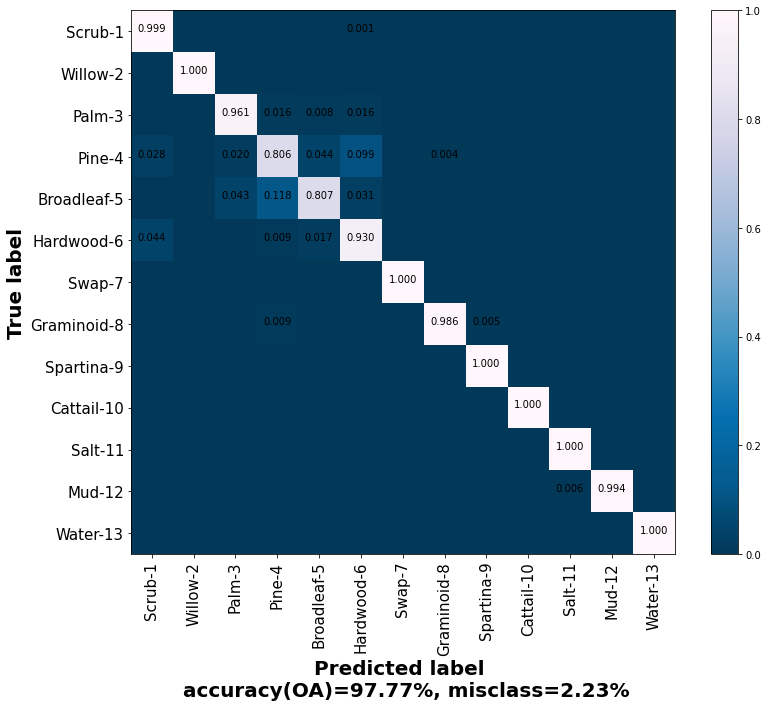

In [16]:
model.eval()
tar_test, pre_test = auxiliary_test_epoch(model, test_loader)  # 收集所有真实标签和预测标签(np.array)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)

# output classification maps
pre_u = auxiliary_valid_epoch(model, true_loader)
prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(total_pos_true.shape[0]):
    prediction_matrix[total_pos_true[i, 0], total_pos_true[i, 1]] = pre_u[i] + 1
cm = confusion_matrix(y_true, pre_u)
plot_confusion_matrix(args.dataset, cm, path='./Confusion_Map_CAEVT.pdf')

In [17]:
print("Final result:")
print("OA: {:.2f}% | AA: {:.2f}% | Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print(AA_test)
print("**************************************************")
print("Parameter:")
print_args(vars(args))

Final result:
OA: 97.52% | AA: 95.56% | Kappa: 0.9724
[0.99853801 1.         0.95652174 0.78318584 0.78472222 0.9223301
 1.         0.98449612 1.         1.         1.         0.99336283
 1.        ]
**************************************************
Parameter:
dataset: KSC
seed: 0
batch_size: 32
patch_size: 9
epoches: 200
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 1
train_proportion: 0.1


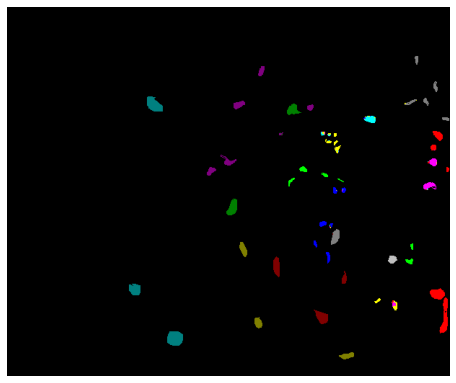

In [18]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

true_map = list_to_colormap(label.ravel())
true_map = np.reshape(true_map, (height, width, 3))
#classification_map(true_map, 300, './GT.pdf')
classification_map(predict_map, './Predict_Map_CAEVT.pdf')